<a href="https://colab.research.google.com/github/Chukwuka1488/MLOps_DTC/blob/main/taxi_trip_duration_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!python -V

Python 3.10.12


In [6]:
# !pip install cudf-cu11 --extra-index-url=https://pypi.ngc.nvidia.com
# !rm -rf /usr/local/lib/python3.8/dist-packages/cupy*
# !pip install cupy-cuda11x

In [7]:
# import cudf

In [8]:
!pip install pyarrow
!pip install pandas
!pip install matplotlib
!pip install seaborn

In [9]:
import pandas as pd
# for parquet files
import pyarrow as pa
import matplotlib.pyplot as plt
import seaborn as sns


In [43]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import numpy as np

### Downloading the data

In [11]:
yellow_taxi_jan_2023 = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet"
yellow_taxi_feb_2023 = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet"

In [12]:
df = pd.read_parquet(yellow_taxi_jan_2023)
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


##### Read the data for January. How many columns are there?

In [13]:
# Assuming 'df' is your DataFrame
columns = df.columns
num_columns = len(columns)

print(f"Columns: {columns}")
print(f"Number of columns: {num_columns}")

Columns: Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')
Number of columns: 19


### Computing duration

In [14]:
df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
df['duration'] = df.duration.apply(lambda td: td.total_seconds() / 60)

In [15]:
df2 = pd.read_parquet(yellow_taxi_feb_2023)
df2.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-02-01 00:32:53,2023-02-01 00:34:34,2.0,0.30,1.0,N,142,163,2,4.4,3.50,0.5,0.0,0.0,1.0,9.40,2.5,0.00
1,2,2023-02-01 00:35:16,2023-02-01 00:35:30,1.0,0.00,1.0,N,71,71,4,-3.0,-1.00,-0.5,0.0,0.0,-1.0,-5.50,0.0,0.00
2,2,2023-02-01 00:35:16,2023-02-01 00:35:30,1.0,0.00,1.0,N,71,71,4,3.0,1.00,0.5,0.0,0.0,1.0,5.50,0.0,0.00
3,1,2023-02-01 00:29:33,2023-02-01 01:01:38,0.0,18.80,1.0,N,132,26,1,70.9,2.25,0.5,0.0,0.0,1.0,74.65,0.0,1.25
4,2,2023-02-01 00:12:28,2023-02-01 00:25:46,1.0,3.22,1.0,N,161,145,1,17.0,1.00,0.5,3.3,0.0,1.0,25.30,2.5,0.00


##### What's the standard deviation of the trips duration in January?

In [16]:
std_dev = df['duration'].std()
print(std_dev)

42.59435124195458


In [17]:
# Check the number of NaNs in column 'A'
num_na = df['duration'].isnull().sum()
print(f"Number of NaNs in column 'duration': {num_na}")

Number of NaNs in column 'duration': 0


### Dropping outliers

Let's check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

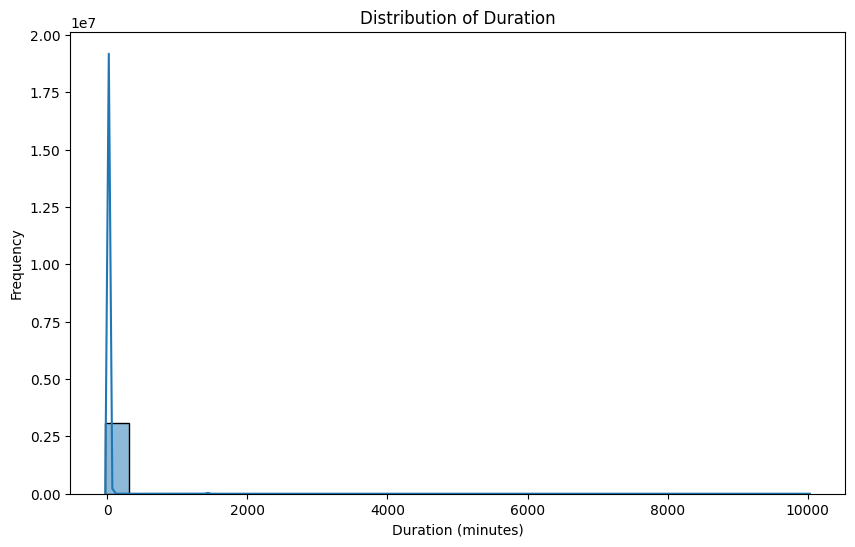

In [18]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['duration'], bins=30, kde=True)
plt.title('Distribution of Duration')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

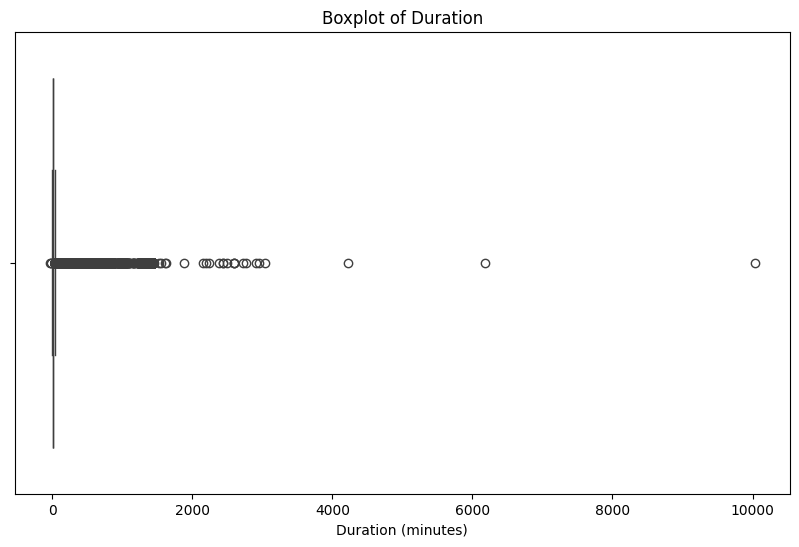

In [19]:
# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['duration'])
plt.title('Boxplot of Duration')
plt.xlabel('Duration (minutes)')
plt.show()

In [20]:
# Filter the DataFrame to remove outliers
df_filtered = df[(df['duration'] >= 1) & (df['duration'] <= 60)]

# Check the first few rows of the filtered DataFrame
df_filtered.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333


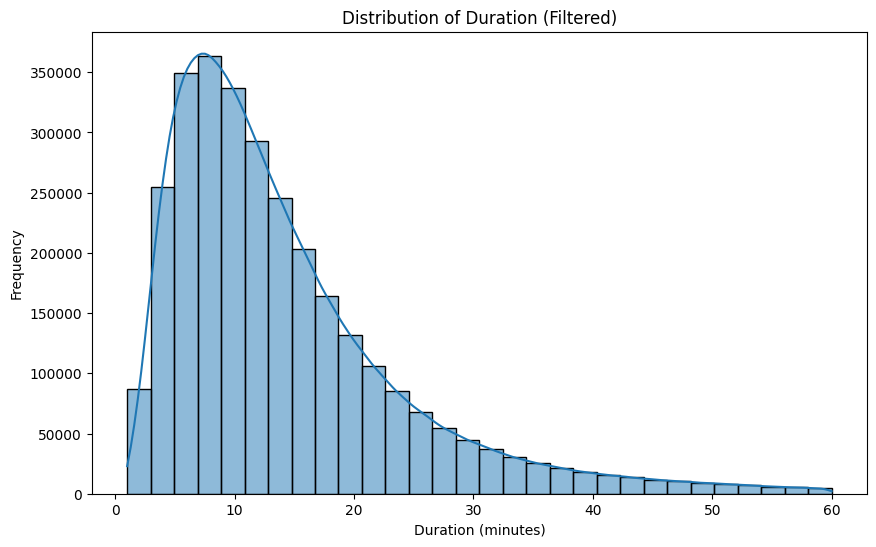

In [21]:
# Distribution of the filtered duration
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['duration'], bins=30, kde=True)
plt.title('Distribution of Duration (Filtered)')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

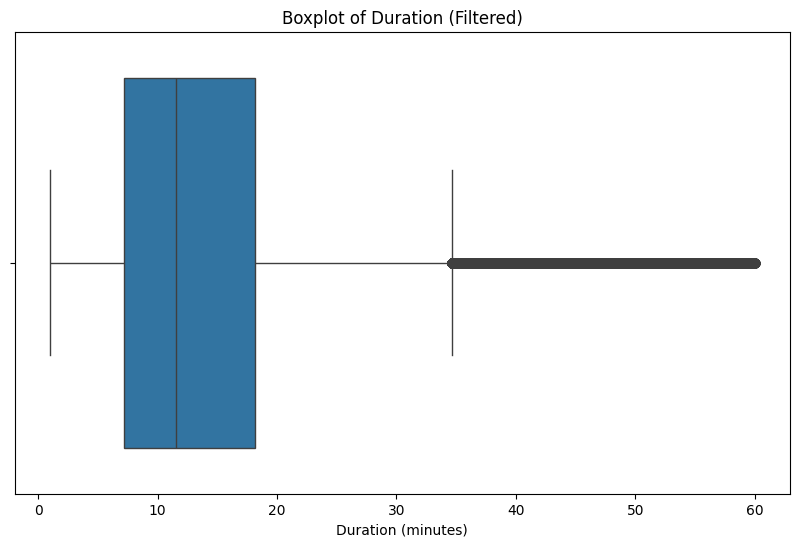

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_filtered['duration'])
plt.title('Boxplot of Duration (Filtered)')
plt.xlabel('Duration (minutes)')
plt.show()

##### What fraction of the records left after you dropped the outliers?

In [23]:
# Total number of records before filtering
total_records_before = len(df)
# Total number of records after filtering
total_records_after = len(df_filtered)
# Compute the fraction of records remaining
fraction_remaining = total_records_after / total_records_before

# Print the results
print(f"Total records before filtering: {total_records_before}")
print(f"Total records after filtering: {total_records_after}")
print(f"Fraction of records remaining: {fraction_remaining:.2f}")

Total records before filtering: 3066766
Total records after filtering: 3009173
Fraction of records remaining: 0.98


### One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

In [24]:
# Convert PULocationID and DOLocationID to strings using .loc to avoid SettingWithCopyWarning
df_filtered.loc[:, 'PULocationID'] = df_filtered['PULocationID'].astype(str)
df_filtered.loc[:, 'DOLocationID'] = df_filtered['DOLocationID'].astype(str)
df_filtered.loc[:, 'VendorID'] = df_filtered['VendorID'].astype(str)

In [25]:
# Apply one-hot encoding to 'PULocationID' and 'DOLocationID' columns
df_encoded = pd.get_dummies(df_filtered, columns=['PULocationID', 'DOLocationID'])
print('One-hot encoding applied successfully.')
df_encoded

One-hot encoding applied successfully.


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,...,DOLocationID_90,DOLocationID_91,DOLocationID_92,DOLocationID_93,DOLocationID_94,DOLocationID_95,DOLocationID_96,DOLocationID_97,DOLocationID_98,DOLocationID_99
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,2,9.30,1.00,...,False,False,False,False,False,False,False,False,False,False
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,1,7.90,1.00,...,False,False,False,False,False,False,False,False,False,False
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,1,14.90,1.00,...,False,False,False,False,False,False,False,False,False,False
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,1,12.10,7.25,...,False,False,False,False,False,False,False,False,False,False
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,1,11.40,1.00,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,None,0,15.80,0.00,...,False,False,False,False,False,False,False,False,False,False
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,None,0,22.43,0.00,...,False,False,False,False,False,False,False,False,False,False
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,None,0,17.61,0.00,...,False,False,False,False,False,False,False,False,False,False
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,None,0,18.15,0.00,...,False,False,False,False,False,False,False,False,False,False


Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)

In [28]:
# Step 4: Select relevant columns (including numerical features and one-hot encoded columns)
selected_columns = ['VendorID', 'trip_distance'] + [col for col in df_encoded.columns if 'PULocationID' in col or 'DOLocationID' in col]
df_selected = df_encoded[selected_columns]

In [29]:
df_selected

,VendorID,trip_distance,PULocationID_1,PULocationID_10,PULocationID_100,PULocationID_101,PULocationID_102,PULocationID_106,PULocationID_107,PULocationID_108,...,DOLocationID_90,DOLocationID_91,DOLocationID_92,DOLocationID_93,DOLocationID_94,DOLocationID_95,DOLocationID_96,DOLocationID_97,DOLocationID_98,DOLocationID_99
0,2,0.97,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,1.10,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2,2.51,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1,1.90,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2,1.43,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,3.05,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3066762,2,5.80,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3066763,2,4.67,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3066764,2,3.15,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [30]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [31]:
data_dicts = df_filtered[categorical + numerical].to_dict(orient='records')
data_dicts

[{'PULocationID': '161', 'DOLocationID': '141', 'trip_distance': 0.97},
 {'PULocationID': '43', 'DOLocationID': '237', 'trip_distance': 1.1},
 {'PULocationID': '48', 'DOLocationID': '238', 'trip_distance': 2.51},
 {'PULocationID': '138', 'DOLocationID': '7', 'trip_distance': 1.9},
 {'PULocationID': '107', 'DOLocationID': '79', 'trip_distance': 1.43},
 {'PULocationID': '161', 'DOLocationID': '137', 'trip_distance': 1.84},
 {'PULocationID': '239', 'DOLocationID': '143', 'trip_distance': 1.66},
 {'PULocationID': '142', 'DOLocationID': '200', 'trip_distance': 11.7},
 {'PULocationID': '164', 'DOLocationID': '236', 'trip_distance': 2.95},
 {'PULocationID': '141', 'DOLocationID': '107', 'trip_distance': 3.01},
 {'PULocationID': '234', 'DOLocationID': '68', 'trip_distance': 1.8},
 {'PULocationID': '79', 'DOLocationID': '264', 'trip_distance': 7.3},
 {'PULocationID': '164', 'DOLocationID': '143', 'trip_distance': 3.23},
 {'PULocationID': '138', 'DOLocationID': '33', 'trip_distance': 11.43},
 {'

##### What's the dimensionality of this matrix (number of columns)?

In [32]:
dv = DictVectorizer()
# Step 6: Fit the vectorizer on the list of dictionaries and transform the data into a feature matrix
features_matrix = dv.fit_transform(data_dicts)

# Step 7: Print the feature names and the feature matrix
print("\nFeature names:\n", dv.get_feature_names_out())
print("\nFeature matrix:\n", features_matrix[:5])

# Step 8: Print the dimensionality of the feature matrix
print("\nDimensionality of the feature matrix (number of columns):", features_matrix.shape[1])


Feature names:
 ['DOLocationID=1' 'DOLocationID=10' 'DOLocationID=100' 'DOLocationID=101'
 'DOLocationID=102' 'DOLocationID=106' 'DOLocationID=107'
 'DOLocationID=108' 'DOLocationID=109' 'DOLocationID=11'
 'DOLocationID=111' 'DOLocationID=112' 'DOLocationID=113'
 'DOLocationID=114' 'DOLocationID=115' 'DOLocationID=116'
 'DOLocationID=117' 'DOLocationID=118' 'DOLocationID=119'
 'DOLocationID=12' 'DOLocationID=120' 'DOLocationID=121'
 'DOLocationID=122' 'DOLocationID=123' 'DOLocationID=124'
 'DOLocationID=125' 'DOLocationID=126' 'DOLocationID=127'
 'DOLocationID=128' 'DOLocationID=129' 'DOLocationID=13'
 'DOLocationID=130' 'DOLocationID=131' 'DOLocationID=132'
 'DOLocationID=133' 'DOLocationID=134' 'DOLocationID=135'
 'DOLocationID=136' 'DOLocationID=137' 'DOLocationID=138'
 'DOLocationID=139' 'DOLocationID=14' 'DOLocationID=140'
 'DOLocationID=141' 'DOLocationID=142' 'DOLocationID=143'
 'DOLocationID=144' 'DOLocationID=145' 'DOLocationID=146'
 'DOLocationID=147' 'DOLocationID=148' 'DOL

### Training a model

Now let's use the feature matrix from the previous step to train a model.
Train a plain linear regression model with default parameters.
Calculate the RMSE of the model on the training data.


What's the RMSE on train?

In [33]:
# Extract the target variable
target = 'duration'
y_train = df_filtered[target].values

# Step 11: Train a plain linear regression model with default parameters
model = LinearRegression()
model.fit(features_matrix, y_train)

# Step 12: Calculate the RMSE of the model on the training data
y_pred = model.predict(features_matrix)

# Using mean_squared_error with squared=False
rmse_direct = mean_squared_error(y_train, y_pred, squared=False)
rmse_direct

7.656752063242953

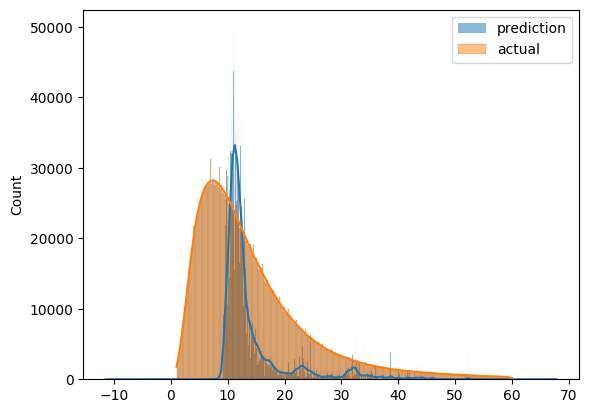

In [34]:
sns.histplot(y_pred, label='prediction', kde=True)
sns.histplot(y_train, label='actual', kde=True)

plt.legend()


### Evaluating the model

In [35]:
def read_dataframe(filename):
    """
    Reads a DataFrame from a file, calculates trip duration, filters outliers,
    and converts categorical columns to strings.

    Parameters:
    filename (str): The path to the file.

    Returns:
    pd.DataFrame: The processed DataFrame.
    """
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)
    else:
        raise ValueError("Unsupported file format")

    # Convert datetime columns to pandas datetime format
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
    df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

    # Calculate duration in minutes
    df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

    # Filter out durations outside the 1 to 60 minute range
    df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]

    # Convert categorical columns to strings
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df

# # File URLs
# yellow_taxi_jan_2023 = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet"
# yellow_taxi_feb_2023 = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet"

In [36]:
# Read data
df_train = read_dataframe(yellow_taxi_jan_2023)
df_val = read_dataframe(yellow_taxi_feb_2023)

print("Training data shape:", df_train.shape)
print("Validation data shape:", df_val.shape)

Training data shape: (3009173, 20)
Validation data shape: (2855951, 20)


In [37]:
len(df_train), len(df_val)

(3009173, 2855951)

In [38]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [39]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [40]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [41]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

5.244464784440393

In [ ]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [ ]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)